In [1]:
import imaging_behavior_functions
#import odor_behavioral_analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.io
import os
import mat73
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from scipy.stats import iqr
from PIL import Image
import cv2
from IPython.display import display, clear_output
import time
import seaborn as sns
from scipy.stats import iqr
from scipy.ndimage import gaussian_filter1d
import glob
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tensorflow as tf
from torchsummary import summary
from scipy.stats import sem
import random
import json
from scipy.integrate import quad
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN
from typing import List
#import h5py
from imaging_behavior_functions import (
    load_intermediate_mat,
    make_df_behavior,
    reconstruct_path,
    get_roi_seq,
    load_dff_raw,
    make_df_neural,
    combine_df,
    extract_heatmap,
    fit_sinusoid
)
import re
import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy.signal import welch
from scipy.spatial.distance import pdist, squareform

In [40]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_imaging/sparse_odor/"
example_path_data = base_path+"20230927-4_MBON09hDeltaB_syntGCAMP7f_10secodor_30isi/data/"
example_path_results = base_path+"20230927-4_MBON09hDeltaB_syntGCAMP7f_10secodor_30isi/results/"
trial_num = 1
odor_threshold = 5
time_interval_threshold = 16  # Assuming time is in seconds or an equivalent unit
k = 8
window_size = 30

is_mat73, roi_df, dff_raw, kinematics_raw, preprocessed_vars_ds, preprocessed_vars_odor = imaging_behavior_functions.load_intermediate_mat(example_path_data,trial_num)
behav_df = imaging_behavior_functions.make_df_behavior(dff_raw, preprocessed_vars_ds, preprocessed_vars_odor,trial_num,ball_d = 9)
xPos, yPos = imaging_behavior_functions.reconstruct_path(behav_df, ball_d = 9)
roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence = imaging_behavior_functions.get_roi_seq(roi_df)
dff_all_rois, dff_time = imaging_behavior_functions.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions.make_df_neural(dff_all_rois, dff_time, roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence)
#roi_kw = 'hDeltaB'
#roi_kw2 = 'MB'
#roi_mtx = imaging_behavior_functions.extract_heatmap(neural_df, roi_kw, roi_kw2,1, example_path_results, trial_num)
#neural_df = imaging_behavior_functions.fit_sinusoid(neural_df,roi_mtx)
#behav_df, padded_result_df, smoothed_df = odor_behavioral_analysis.analysis_dfs(behav_df, time_interval_threshold, k, window_size)
#merged_df = imaging_behavior_functions.combine_df(behav_df, neural_df)
#smoothed_df["translationalV_smoothed"] = np.sqrt(smoothed_df["fwV_smoothed"]**2+smoothed_df["sideV_smoothed"]**2)

In [2]:
# functions for characterizing the odor state

def analyze_odor_time_series(df, odor_col="odor_state", time_col="time"):
    """
    Computes various metrics from an odor stimulus time series.
    
    Parameters:
    - df (pd.DataFrame): DataFrame with 'time' and 'odor_state' (binary 0/1).
    - odor_col (str): Column name for odor state (default: 'odor_state').
    - time_col (str): Column name for time values (default: 'time').
    
    Returns:
    - dict: Computed metrics.
    """
    results = {}

    # Ensure time is sorted
    df = df.sort_values(by=time_col).reset_index(drop=True)
    
    # Compute transitions
    transitions = df[odor_col].diff().dropna().abs()  # 1 for state change, 0 otherwise
    num_transitions = transitions.sum()
    total_time = df[time_col].iloc[-1] - df[time_col].iloc[0]

    # Mean transition rate
    results["mean_transition_rate"] = num_transitions / total_time if total_time > 0 else 0

    # Compute inter-event intervals (time between transitions)
    transition_times = df[time_col][transitions > 0].values
    inter_event_intervals = np.diff(transition_times)

    if len(inter_event_intervals) > 1:
        results["inter_event_interval_mean"] = np.mean(inter_event_intervals)
        results["inter_event_interval_std"] = np.std(inter_event_intervals)
        results["fano_factor"] = np.var(inter_event_intervals) / np.mean(inter_event_intervals) if np.mean(inter_event_intervals) > 0 else 0
    else:
        results["inter_event_interval_mean"] = 0
        results["inter_event_interval_std"] = 0
        results["fano_factor"] = 0

    # Shannon Entropy of state probabilities
    p_on = df[odor_col].mean()
    p_off = 1 - p_on
    results["shannon_entropy"] = entropy([p_on, p_off], base=2) if p_on > 0 and p_off > 0 else 0

    # Conditional Entropy: Approximate using transition probabilities
    P_on_to_off = num_transitions / df[odor_col].sum() if df[odor_col].sum() > 0 else 0
    P_off_to_on = num_transitions / (len(df) - df[odor_col].sum()) if (len(df) - df[odor_col].sum()) > 0 else 0

    if P_on_to_off > 0 and P_off_to_on > 0:
        results["conditional_entropy"] = - (P_on_to_off * np.log2(P_on_to_off) + P_off_to_on * np.log2(P_off_to_on))
    else:
        results["conditional_entropy"] = 0

    # Power Spectrum Analysis (Fourier Transform for frequency content)
    fs = 1 / np.median(np.diff(df[time_col])) if len(df) > 1 else 1  # Sampling frequency
    f, Pxx = welch(df[odor_col], fs=fs, nperseg=min(256, len(df)))
    results["dominant_frequency"] = f[np.argmax(Pxx)] if len(f) > 0 else 0

    # Duty Cycle
    results["duty_cycle"] = p_on

    # Autocorrelation (First Lag)
    if len(df) > 1:
        autocorr = np.corrcoef(df[odor_col][:-1], df[odor_col][1:])[0, 1]
        results["autocorrelation_first_lag"] = autocorr if not np.isnan(autocorr) else 0
    else:
        results["autocorrelation_first_lag"] = 0

    return results

# Example Usage
# df = pd.DataFrame({'time': np.arange(0, 100, 1), 'odor_state': np.random.choice([0, 1], size=100)})
# results = analyze_odor_time_series(df)
# print(results)


In [3]:
def calculate_odor_metrics(df):
    """
    Calculate odor on duration and past interval for all odor onsets.

    Args:
        df (pd.DataFrame): Dataframe with 'time' and 'odor_state' columns.

    Returns:
        pd.DataFrame: Dataframe with additional columns for 'odor_duration' and 'past_interval'.
    """
    if "time" not in df.columns or "odor_state" not in df.columns:
        raise ValueError("The dataframe must contain 'time' and 'odor_state' columns.")

    # Find indices where odor transitions occur
    onset_indices = df.index[(df["odor_state"].shift(1, fill_value=0) == 0) & (df["odor_state"] == 1)]
    offset_indices = df.index[(df["odor_state"].shift(1, fill_value=0) == 1) & (df["odor_state"] == 0)]

    # Ensure onset and offset indices are aligned
    odor_metrics = []
    for onset_idx in onset_indices:
        # Find the first offset after the onset
        offset_idx = offset_indices[offset_indices > onset_idx].min()

        if pd.notna(offset_idx):
            # Calculate odor duration
            odor_duration = df.loc[offset_idx, "time"] - df.loc[onset_idx, "time"]

            # Calculate past interval (time since the last offset)
            last_offset_idx = offset_indices[offset_indices < onset_idx].max()
            past_interval = (
                df.loc[onset_idx, "time"] - df.loc[last_offset_idx, "time"]
                if pd.notna(last_offset_idx)
                else None
            )

            odor_metrics.append({
                "onset_time": df.loc[onset_idx, "time"],
                "odor_duration": odor_duration,
                "past_interval": past_interval,
            })

    # Convert results to a dataframe
    metrics_df = pd.DataFrame(odor_metrics)

    return metrics_df


In [44]:
def contains_keyword(df, keyword):
    return df.astype(str).apply(lambda col: col.str.contains(keyword, na=False)).any().any()

def process_all_trials(base_path, odor_threshold=5, time_interval_threshold=16, k=8, window_size=30):
    all_data = []
    flyid = 0

    # Iterate over each folder in the base path
    for fly_folder in os.listdir(base_path):
        fly_folder_path = os.path.join(base_path, fly_folder)

        if not os.path.isdir(fly_folder_path):
            continue

        data_path = os.path.join(fly_folder_path, "data/")

        if not os.path.exists(data_path):
            print(f"Data folder not found: {data_path}")
            continue

        # Find all trial numbers by checking files like dff_raw_trialx.mat
        trial_files = [f for f in os.listdir(data_path) if re.match(r"dff raw trial\d+\.mat", f)]
        trial_numbers = [int(re.search(r"\d+", f).group()) for f in trial_files]

        for trial_num in trial_numbers:
            try:
                # Load the intermediate MAT file
                (
                    is_mat73,
                    roi_df,
                    dff_raw,
                    kinematics_raw,
                    preprocessed_vars_ds,
                    preprocessed_vars_odor,
                ) = load_intermediate_mat(data_path, trial_num)

                # Process behavioral and neural data
                behav_df = make_df_behavior(dff_raw, preprocessed_vars_ds, preprocessed_vars_odor, trial_num, ball_d=9)
                xPos, yPos = reconstruct_path(behav_df, ball_d=9)
                (
                    roi_names,
                    hdeltab_index,
                    epg_index,
                    fr1_index,
                    hdeltab_sequence,
                    epg_sequence,
                    fr1_sequence,
                ) = get_roi_seq(roi_df)
                dff_all_rois, dff_time = load_dff_raw(is_mat73, dff_raw)
                neural_df = make_df_neural(
                    dff_all_rois,
                    dff_time,
                    roi_names,
                    hdeltab_index,
                    epg_index,
                    fr1_index,
                    hdeltab_sequence,
                    epg_sequence,
                    fr1_sequence,
                )
                roi_kw = 'hDeltaB'
                roi_kw2 = 'MB'
                if len([col for col in neural_df.columns if roi_kw.lower() in col.lower()])>0:
                    #print(1)
                    roi_mtx = extract_heatmap(neural_df, roi_kw, roi_kw2,1, example_path_results, trial_num)
                    neural_df = fit_sinusoid(neural_df,roi_mtx)

                # Combine behavioral and neural dataframes
                merged_df = combine_df(behav_df, neural_df)

                # Add odor_state column based on odor_threshold
                merged_df["odor_state"] = (merged_df["odor"] > 0.5).astype(int)

                # Calculate odor metrics: duration and past interval
                onset_indices = merged_df.index[(merged_df["odor_state"].shift(1, fill_value=0) == 0) & (merged_df["odor_state"] == 1)]
                offset_indices = merged_df.index[(merged_df["odor_state"].shift(1, fill_value=0) == 1) & (merged_df["odor_state"] == 0)]

                merged_df["odor_duration"] = np.nan
                merged_df["past_interval"] = np.nan

                for onset_idx in onset_indices:
                    # Find the first offset after the onset
                    offset_idx = offset_indices[offset_indices > onset_idx].min()

                    if pd.notna(offset_idx):
                        # Calculate odor duration
                        odor_duration = merged_df.loc[offset_idx, "time"] - merged_df.loc[onset_idx, "time"]
                        merged_df.loc[onset_idx, "odor_duration"] = odor_duration

                    # Calculate past interval
                    last_offset_idx = offset_indices[offset_indices < onset_idx].max()
                    if pd.notna(last_offset_idx):
                        past_interval = merged_df.loc[onset_idx, "time"] - merged_df.loc[last_offset_idx, "time"]
                    else:
                        past_interval = merged_df.loc[onset_idx, "time"] - merged_df["time"].iloc[0]
                    merged_df.loc[onset_idx, "past_interval"] = past_interval

                # Add flyid and trialid columns
                merged_df["flyid"] = flyid
                merged_df["trialid"] = trial_num

                # Append to all_data
                all_data.append(merged_df)

            except Exception as e:
                print(f"Error processing trial {trial_num} in {fly_folder}: {e}")

        flyid += 1

    # Concatenate all dataframes
    if all_data:
        concatenated_df = pd.concat(all_data, ignore_index=True)
        return concatenated_df
    else:
        print("No data processed.")
        return None

In [45]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_imaging/sparse_odor/"
combined_df = process_all_trials(base_path)

Loading with scipy.io failed: Please use HDF reader for matlab v7.3 files, e.g. h5py. Trying with mat73.
Loading with scipy.io failed: Please use HDF reader for matlab v7.3 files, e.g. h5py. Trying with mat73.
Loading with scipy.io failed: Please use HDF reader for matlab v7.3 files, e.g. h5py. Trying with mat73.
Loading with scipy.io failed: Please use HDF reader for matlab v7.3 files, e.g. h5py. Trying with mat73.
Loading with scipy.io failed: Please use HDF reader for matlab v7.3 files, e.g. h5py. Trying with mat73.
Loading with scipy.io failed: Please use HDF reader for matlab v7.3 files, e.g. h5py. Trying with mat73.
Loading with scipy.io failed: Please use HDF reader for matlab v7.3 files, e.g. h5py. Trying with mat73.
Loading with scipy.io failed: Please use HDF reader for matlab v7.3 files, e.g. h5py. Trying with mat73.
Loading with scipy.io failed: Please use HDF reader for matlab v7.3 files, e.g. h5py. Trying with mat73.
Loading with scipy.io failed: Please use HDF reader for

In [46]:
combined_df.amplitude

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
163948   NaN
163949   NaN
163950   NaN
163951   NaN
163952   NaN
Name: amplitude, Length: 163953, dtype: float64

In [90]:
def gaussian_smooth(column, sigma):
    """Applies Gaussian smoothing to a dataframe column.

    Args:
        column (pd.Series): The column to smooth.
        sigma (float): The standard deviation of the Gaussian kernel.

    Returns:
        pd.Series: Smoothed column.
    """
    from scipy.ndimage import gaussian_filter1d

    smoothed = gaussian_filter1d(column.values, sigma=sigma)
    return pd.Series(smoothed, index=column.index)


def plot_neural_activity(df, pre_window_size, post_window_size,plot_columns=["MBON09L", "MBON09R", "MBON21L", "MBON21R"],sigma=None,plot_kw = 'interval',bounds=[10, 25, 100, 200]):
    #neural_columns = ["MBON09L", "MBON09R", "MBON21L", "MBON21R"]

    for column in plot_columns:
        if column not in df.columns:
            raise ValueError(f"Column {column} not found in the dataframe.")

    if "time" not in df.columns:
        raise ValueError("Column 'time' not found in the dataframe.")

    # Apply Gaussian smoothing to the entire columns if sigma is provided
    if sigma:
        for column in plot_columns:
            if column != "heading":
                smoothed_column_name = f"{column}_smoothed"
                df[smoothed_column_name] = gaussian_smooth(df[column], sigma)

    # Filter rows where odor_state transitions from 0 to 1
    odor_onsets = df.index[(df["odor_state"].shift(1, fill_value=0) == 0) & (df["odor_state"] == 1)]

    fig, axs = plt.subplots(len(plot_columns)//2, 2, figsize=(12, 2*len(plot_columns)))
    axs = axs.ravel()

    for i, column in enumerate(plot_columns):
        aligned_traces = []
        trace_colors = []
        unique_values = []
        if column != "heading":
        # Use the smoothed column if sigma is provided
            column = f"{column}_smoothed" if sigma else column

        for onset in odor_onsets:
            start = max(0, onset - pre_window_size)
            end = min(len(df), onset + post_window_size)

            # Extract trace and corresponding time centered around odor onset
            trace = df[column].iloc[start:end].reset_index(drop=True)
            time_trace = df["time"].iloc[start:end] - df["time"].iloc[onset]
            #print(np.array(time_trace)[-1]) 
            if np.array(time_trace)[-1] >0:
            # Align traces without "normalization"
                aligned_traces.append((time_trace.reset_index(drop=True), trace))
            # Determine the color based on plot_kw
                if plot_kw == "duration":
                    value = df.loc[onset, "odor_duration"]
                elif plot_kw == "interval":
                    value = df.loc[onset, "past_interval"]
                else:
                    value = None
                if value is not None:
                    trace_colors.append(value)
                    unique_values.append(value)
        #print(trace_colors)
        # Compute average trace
        mean_trace = pd.DataFrame([trace for _, trace in aligned_traces]).mean()
        # Normalize trace_colors for colormap
        if trace_colors:
            norm = plt.Normalize(min(trace_colors), 250)
            cmap = plt.cm.rainbow
        # Plot individual traces with color mapping
        #print(len(aligned_traces))
        #print(len(trace_colors))
        for idx, (time_trace, trace) in enumerate(aligned_traces):
            color = cmap(norm(trace_colors[idx])) if trace_colors else "blue"
            axs[i].plot(time_trace, trace, alpha=0.1, color=color)

        # Group traces by bounds
        grouped_traces = {"0": [], "1": [], "2": [], "3": [],"4": []}
        for idx, value in enumerate(trace_colors):
            if value < bounds[0]:
                grouped_traces["0"].append(aligned_traces[idx][1])
            elif bounds[0] <= value <= bounds[1]:
                grouped_traces["1"].append(aligned_traces[idx][1])
            elif bounds[1] < value <= bounds[2]:
                grouped_traces["2"].append(aligned_traces[idx][1])
            elif bounds[2] < value <= bounds[3]:
                grouped_traces["3"].append(aligned_traces[idx][1])
            else:
                grouped_traces["4"].append(aligned_traces[idx][1])

        # Plot average traces for each group, colored by average plot_kw value
        for group, traces in grouped_traces.items():
            if traces:
                # Calculate the mean trace
                mean_trace = pd.DataFrame(traces).mean()
                mean_time = pd.Series(
                    [-pre_window_size + i for i in range(pre_window_size + post_window_size)]
                )
                
                # Calculate the average plot_kw value for this group
                group_values = [trace_colors[idx] for idx, value in enumerate(trace_colors) if 
                                (value < bounds[0] and group == "0") or
                                (bounds[0] <= value <= bounds[1] and group == "1") or
                                (bounds[1] < value <= bounds[2] and group == "2") or
                                (bounds[2] < value <= bounds[3] and group == "3") or
                                (bounds[3] < value and group == "4")]
        
            if group_values:
                group_avg = np.mean(group_values)
                color = cmap(norm(group_avg))  # Use the average plot_kw value for coloring
                axs[i].plot(time_trace, mean_trace, color=color, label=f"{group} (avg: {group_avg:.2f})")

        # Add red dotted line for odor onset
        axs[i].axvline(x=0, color='red', linestyle='--', label='Odor Onset')
        # Add color bar for the colormap
        if trace_colors:
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=axs[i])
            cbar.set_label(f"{plot_kw.capitalize()} Value")
        axs[i].set_title(f"Neural Activity: {column}")
        axs[i].set_xlabel("Time (seconds, aligned to odor onset)")
        #axs[i].set_limit(-pre_window_size, post_window_size)
        axs[i].set_ylabel("Activity")
        #axs[i].legend()

    plt.tight_layout()
    plt.show()


def plot_neural_activity_2(df, pre_window_size, post_window_size, plot_columns=["MBON09L", "MBON09R", "MBON21L", "MBON21R"],
                         sigma=None, plot_kw='interval', bounds=[10, 25, 100, 200], velocity_threshold=0):
    
    for column in plot_columns:
        if column not in df.columns:
            raise ValueError(f"Column {column} not found in the dataframe.")
    
    if "time" not in df.columns or "fwV" not in df.columns:
        raise ValueError("Columns 'time' or 'fwV' not found in the dataframe.")

    # Apply Gaussian smoothing if needed
    if sigma:
        for column in plot_columns:
            if column != "heading":
                smoothed_column_name = f"{column}_smoothed"
                df[smoothed_column_name] = gaussian_smooth(df[column], sigma)

    # Find odor onset times
    odor_onsets = df.index[(df["odor_state"].shift(1, fill_value=0) == 0) & (df["odor_state"] == 1)]

    fig, axs = plt.subplots(len(plot_columns), 2, figsize=(12, 4 * len(plot_columns)))
    axs = axs.ravel()

    for i, column in enumerate(plot_columns):
        aligned_traces_slow = []
        aligned_traces_fast = []
        trace_colors_slow = []
        trace_colors_fast = []

        # Use smoothed column if sigma is provided
        column = f"{column}_smoothed" if sigma else column

        for onset in odor_onsets:
            start = max(0, onset - pre_window_size)
            end = min(len(df), onset + post_window_size)

            # Compute average pre-window forward velocity
            pre_window_fwd_velocity = df["fwV_smoothed"].iloc[start:onset].mean()

            # Extract trace and corresponding time centered around odor onset
            trace = df[column].iloc[start:end].reset_index(drop=True)
            time_trace = df["time"].iloc[start:end] - df["time"].iloc[onset]

            if np.array(time_trace)[-1] > 0:  # Ensure trace is long enough
                if pre_window_fwd_velocity < velocity_threshold:
                    aligned_traces_slow.append((time_trace.reset_index(drop=True), trace))
                else:
                    aligned_traces_fast.append((time_trace.reset_index(drop=True), trace))

                # Determine color based on plot_kw
                if plot_kw == "duration":
                    value = df.loc[onset, "odor_duration"]
                elif plot_kw == "interval":
                    value = df.loc[onset, "past_interval"]
                else:
                    value = None
                
                if value is not None:
                    if pre_window_fwd_velocity < velocity_threshold:
                        trace_colors_slow.append(value)
                    else:
                        trace_colors_fast.append(value)

        # Compute colormap normalization
        all_trace_colors = trace_colors_slow + trace_colors_fast
        if all_trace_colors:
            norm = plt.Normalize(min(all_trace_colors), max(all_trace_colors))
            cmap = plt.cm.rainbow

        # Helper function to group traces based on bounds
        def group_traces_by_bounds(aligned_traces, trace_colors, bounds):
            grouped_traces = {str(i): [] for i in range(len(bounds) + 1)}

            for idx, value in enumerate(trace_colors):
                if value < bounds[0]:
                    grouped_traces["0"].append(aligned_traces[idx][1])
                elif bounds[0] <= value <= bounds[1]:
                    grouped_traces["1"].append(aligned_traces[idx][1])
                elif bounds[1] < value <= bounds[2]:
                    grouped_traces["2"].append(aligned_traces[idx][1])
                elif bounds[2] < value <= bounds[3]:
                    grouped_traces["3"].append(aligned_traces[idx][1])
                else:
                    grouped_traces["4"].append(aligned_traces[idx][1])

            # Remove empty groups to prevent errors
            grouped_traces = {k: v for k, v in grouped_traces.items() if v}

            return grouped_traces


        # Group traces by bounds
        grouped_traces_slow = group_traces_by_bounds(aligned_traces_slow, trace_colors_slow, bounds)
        grouped_traces_fast = group_traces_by_bounds(aligned_traces_fast, trace_colors_fast, bounds)

        # Plot traces for slow and fast trials
        for group, traces in grouped_traces_slow.items():
            if traces:
                mean_trace = pd.DataFrame(traces).mean()
                mean_time = pd.Series(
                    [-pre_window_size + i for i in range(pre_window_size + post_window_size)]
                )
                group_avg = np.mean([trace_colors_slow[idx] for idx, value in enumerate(trace_colors_slow) if 
                                     (value < bounds[0] and group == "0") or
                                     (bounds[0] <= value <= bounds[1] and group == "1") or
                                     (bounds[1] < value <= bounds[2] and group == "2") or
                                     (bounds[2] < value <= bounds[3] and group == "3") or
                                     (bounds[3] < value and group == "4")])
                color = cmap(norm(group_avg))
                axs[2 * i].plot(time_trace, mean_trace, color=color, label=f"{group} (avg: {group_avg:.2f})")

        for group, traces in grouped_traces_fast.items():
            if traces:
                mean_trace = pd.DataFrame(traces).mean()
                mean_time = pd.Series(
                    [-pre_window_size + i for i in range(pre_window_size + post_window_size)]
                )
                group_avg = np.mean([trace_colors_fast[idx] for idx, value in enumerate(trace_colors_fast) if 
                                     (value < bounds[0] and group == "0") or
                                     (bounds[0] <= value <= bounds[1] and group == "1") or
                                     (bounds[1] < value <= bounds[2] and group == "2") or
                                     (bounds[2] < value <= bounds[3] and group == "3") or
                                     (bounds[3] < value and group == "4")])
                color = cmap(norm(group_avg))
                axs[2 * i + 1].plot(time_trace, mean_trace, color=color, label=f"{group} (avg: {group_avg:.2f})")
        # Plot traces for slow trials
        for idx, (time_trace, trace) in enumerate(aligned_traces_slow):
            color = cmap(norm(trace_colors_slow[idx])) if trace_colors_slow else "blue"
            axs[2 * i].plot(time_trace, trace, alpha=0.01, color=color)

        # Plot traces for fast trials
        for idx, (time_trace, trace) in enumerate(aligned_traces_fast):
            color = cmap(norm(trace_colors_fast[idx])) if trace_colors_fast else "blue"
            axs[2 * i + 1].plot(time_trace, trace, alpha=0.05, color=color)
        # Add odor onset line
        axs[2 * i].axvline(x=0, color='red', linestyle='--', label='Odor Onset')
        axs[2 * i + 1].axvline(x=0, color='red', linestyle='--', label='Odor Onset')

        # Titles and labels
        axs[2 * i].set_title(f"{column} - Slow Trials (< {velocity_threshold} cm/s)")
        axs[2 * i + 1].set_title(f"{column} - Fast Trials (>= {velocity_threshold} cm/s)")
        axs[2 * i].set_xlabel("Time (s, aligned to odor onset)")
        axs[2 * i + 1].set_xlabel("Time (s, aligned to odor onset)")
        axs[2 * i].set_ylabel("Activity")
        #axs[2 * i].set_ylim([])
        axs[2 * i + 1].set_ylabel("Activity")

    plt.tight_layout()
    plt.show()


#### MBON09/21 response colored by prior stimulus interval

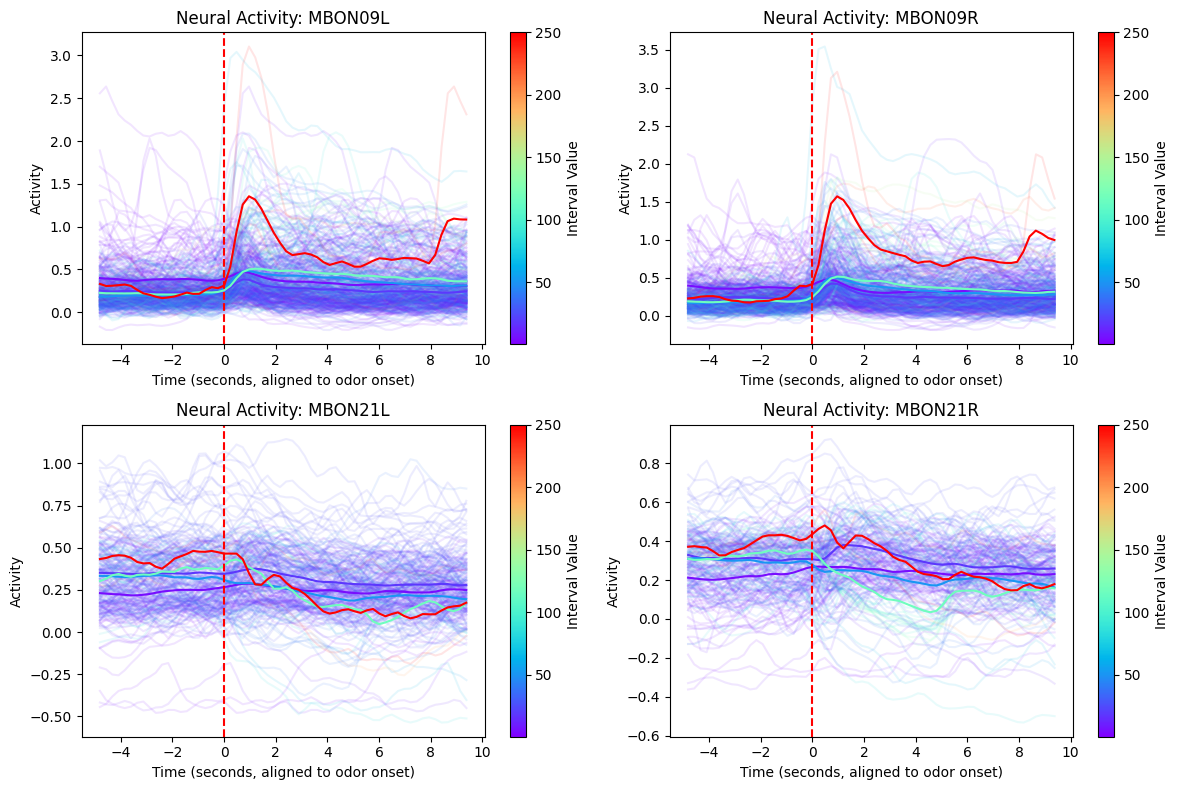

In [50]:
plot_neural_activity(combined_df, pre_window_size=20, post_window_size=40)

#### MBON09/21 response colored by duration

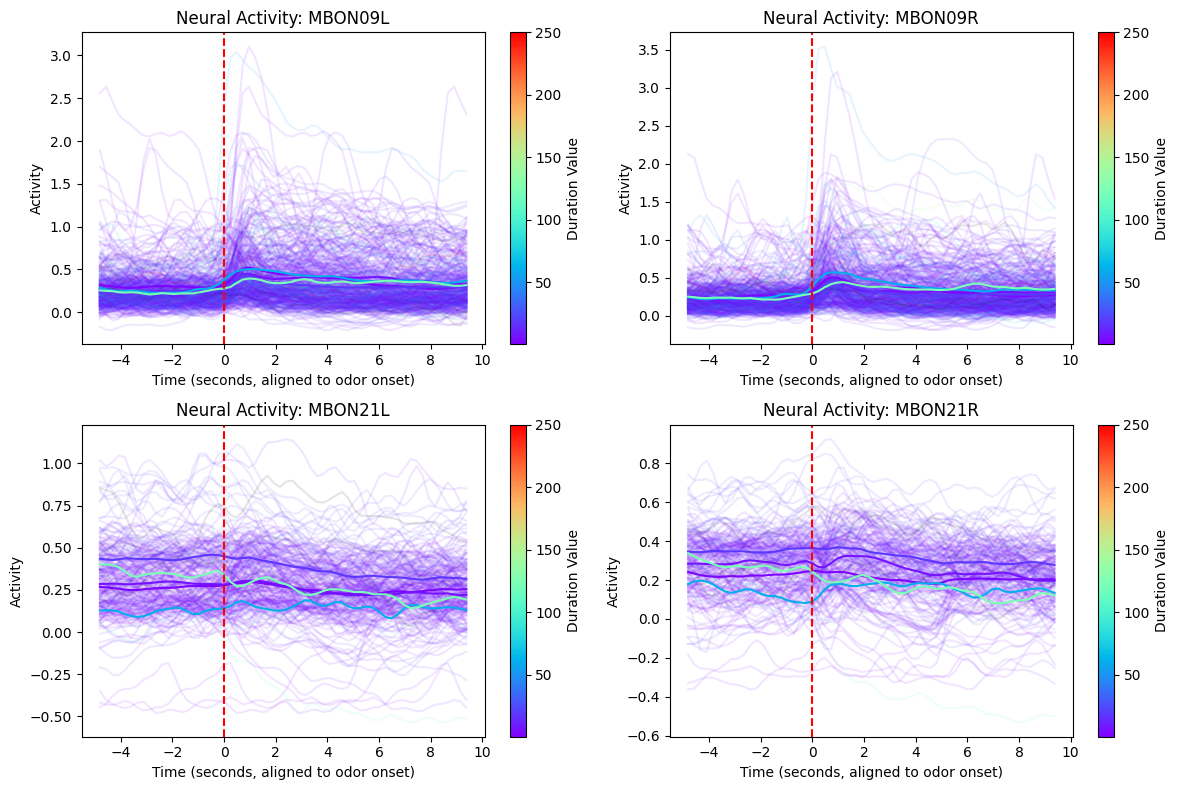

In [51]:
plot_neural_activity(combined_df, pre_window_size=20, post_window_size=40,plot_kw = 'duration',bounds=[5, 10, 40,100])

#### hDeltaB amplitude and mean responses colored by interval

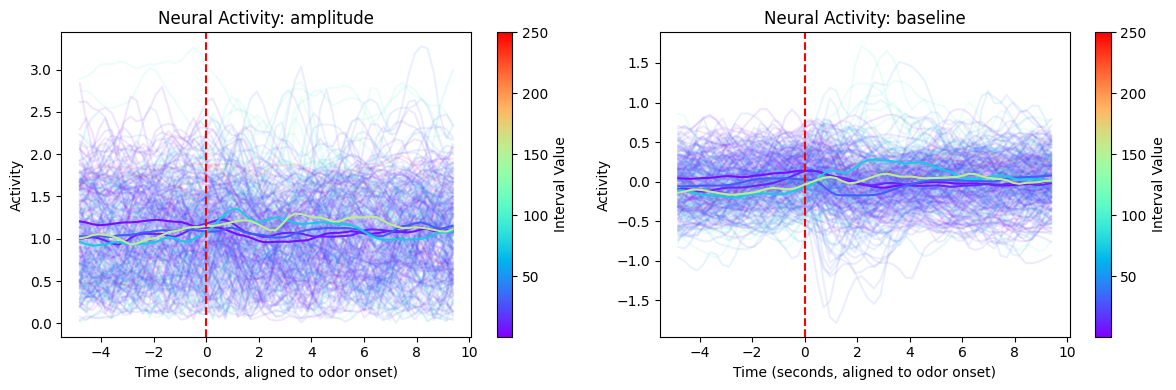

In [56]:
plot_neural_activity(combined_df, pre_window_size=20, post_window_size=40,plot_columns=["amplitude","baseline"],bounds=[10, 20, 50, 100])

#### hDeltaB amplitude and mean responses colored by duration

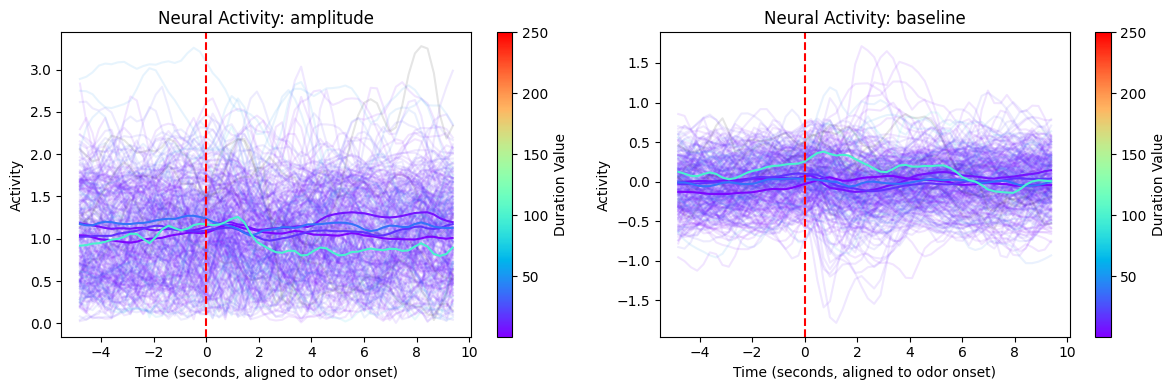

In [63]:
plot_neural_activity(combined_df, pre_window_size=20, post_window_size=40,plot_columns=["amplitude","baseline"],plot_kw = 'duration',bounds=[5, 10, 25,60])

#### FwV and yawV responses

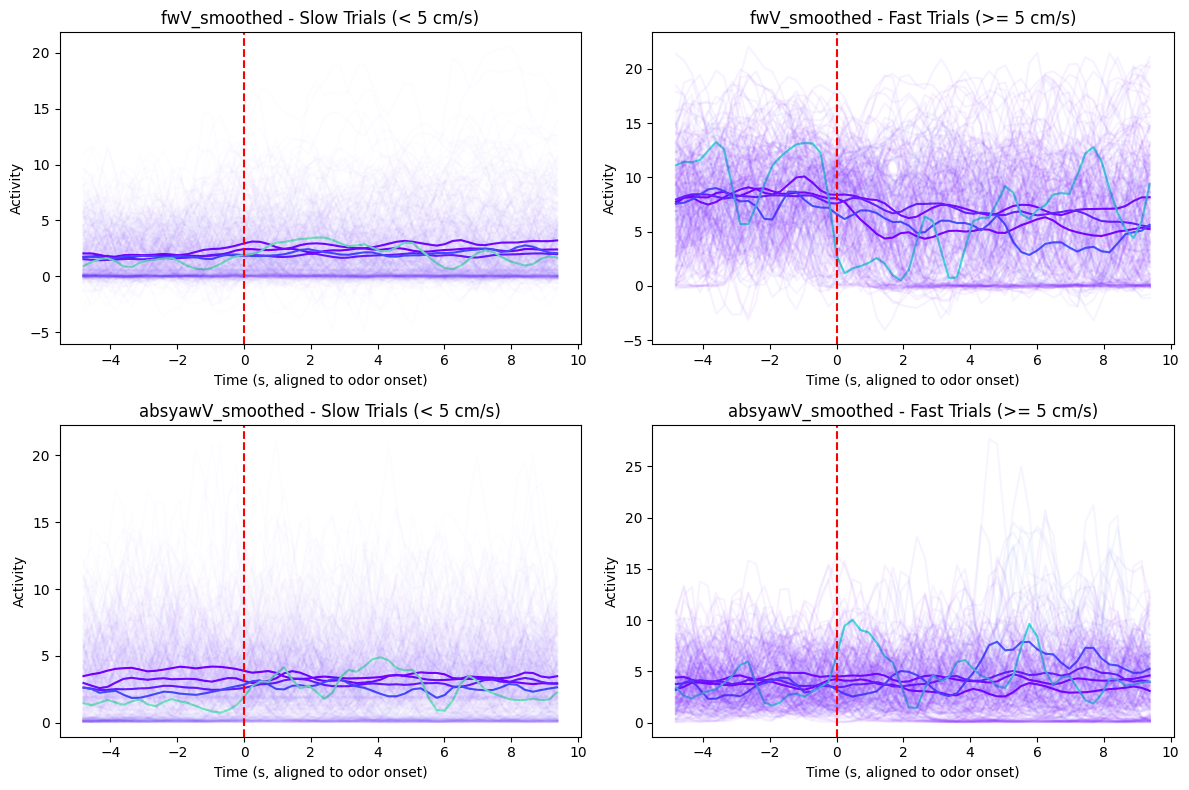

In [91]:
plot_neural_activity_2(combined_df, pre_window_size=20, post_window_size=40, plot_columns=["fwV", "absyawV"],sigma = 1,velocity_threshold=5,bounds=[10, 25, 100, 200])

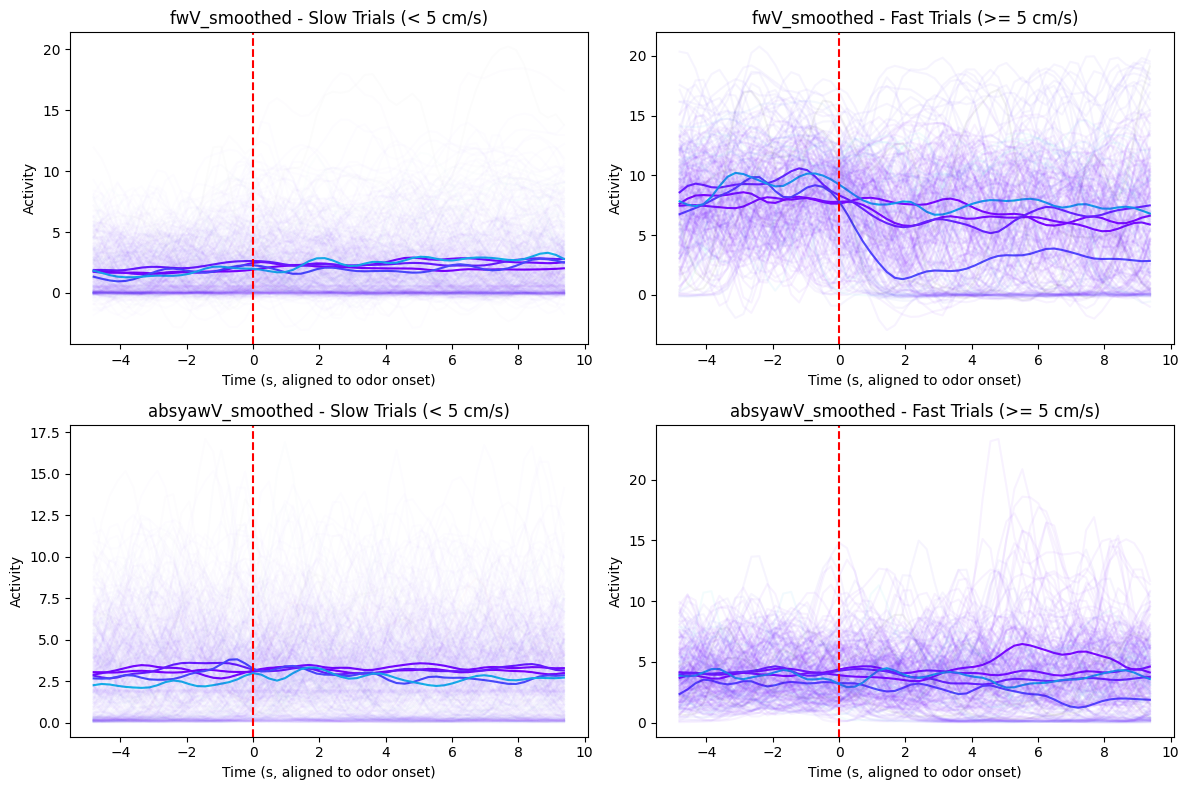

In [92]:
plot_neural_activity_2(combined_df, pre_window_size=20, post_window_size=40, plot_columns=["fwV", "absyawV"],sigma = 1.5,plot_kw = 'duration', velocity_threshold=5,bounds=[5, 10, 25, 50])